In [2]:
import importlib
from typing import Dict, Tuple
from matplotlib import pyplot as plt
from shared.definitions import TuningResult
from shared.ml_config_core import ModelTrainingResult
from shared import stats_utils
from shared.ml_config_runner import build_production_model_for_tuning_result
from shared import graph
from shared import utils
import seaborn as sns
import pandas as pd
import xgboost
from Draft import feature_builder_v2
import importlib
import xgboost as xgb

# import matplotlib.pyplot as plt
VERBOSE = False
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")
# Use this to select the model to train, gennerally there are certain advantages and disadvantages between using different tuning targets:
# e.g. F1 provides better classification accuracy
# PR-AUC however is only slightly worse but has much smoother probabilities which is more
# useful when when selecting thresholds for grades
INCLUDE_MODELS = [
    'Baseline_Only_CreditRatings',
    'LGBM_AUC_Base_Features',
    'LGBM_Weighted_LogLoss',
    'LGBM_AUC',
    'LGBM_AUC_150_trials',
    'LGBM_AUC_prev_075',
    'LGBM_Dart_AUC',
    'LGBM_AUC_All_Features'
]
importlib.reload(feature_builder_v2)
# features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True, ds_type=feature_builder_v2.DatasetType.FULL)


<module 'Draft.feature_builder_v2' from 'V:\\projects\\ppuodz-ML.4.1\\Draft\\feature_builder_v2.py'>

In [ ]:
results_all_models: Dict[str, Tuple[TuningResult, ModelTrainingResult]] = {}

for model_key in INCLUDE_MODELS:
    tuning_result = TuningResult.load_serialized_tuning_result(model_key)

    cv_results = build_production_model_for_tuning_result(
        tuning_result=tuning_result, load_df=feature_builder_v2.load_datasets_and_prepare_features
    )
    results_all_models[model_key] = (tuning_result, cv_results)

    ModelTrainingResult.serialize_model(cv_results, model_key)

In [4]:
def aggregate_results_to_table(results: Dict[str, Tuple[TuningResult, ModelTrainingResult]], validation_results=False):
    rows = []
    for model_key, model_data in results.items():
        model_results = model_data[1]

        results = model_results.cv_metrics if validation_results else model_results.test_data.metrics_2

        metrics = {f'{k}': round(v, 3) for k, v in results.items()}
        metrics = {'Model': model_key, **metrics}  # Add model key to the metrics dictionary
        rows.append(metrics)
    results_df = pd.DataFrame(rows).sort_values(by="auc", ascending=False)
    results_df.to_csv(f"data/results_all_models_{'validation' if validation_results else 'test'}.csv", index=False)
    return results_df

##### Model Results Comparison (5-fold CV)

In [5]:
aggregate_results_to_table(results_all_models, validation_results=True)

,Model,auc,pr_auc,_f1_micro,_f1_macro,logloss,accuracy,precision_macro,recall_macro,f1_macro,target_f1,target_recall,target_precision,fbeta_1.5,fbeta_2.5,fbeta_4.0,log_loss
6,LGBM_Dart_AUC,0.775,0.262,0.732,0.561,9.674,0.732,0.573,0.705,0.561,0.288,0.673,0.183,0.369,0.492,0.581,0.537
3,LGBM_AUC,0.774,0.261,0.730,0.560,9.738,0.730,0.572,0.704,0.560,0.287,0.673,0.182,0.368,0.491,0.581,0.537
4,LGBM_AUC_150_trials,0.774,0.260,0.728,0.559,9.805,0.728,0.572,0.704,0.559,0.286,0.676,0.182,0.368,0.492,0.583,0.544
5,LGBM_AUC_prev_075,0.773,0.259,0.730,0.560,9.719,0.730,0.572,0.702,0.560,0.286,0.669,0.182,0.367,0.488,0.578,0.536
7,LGBM_AUC_All_Features,0.773,0.260,0.741,0.565,9.353,0.741,0.574,0.702,0.565,0.290,0.655,0.186,0.369,0.486,0.571,0.525
1,LGBM_AUC_Base_Features,0.757,0.239,0.715,0.548,10.279,0.715,0.566,0.691,0.548,0.273,0.663,0.172,0.353,0.475,0.567,0.561
2,LGBM_Weighted_LogLoss,0.754,0.236,0.745,0.562,9.176,0.745,0.569,0.684,0.562,0.279,0.610,0.181,0.353,0.460,0.536,0.525
0,Baseline_Only_CreditRatings,0.723,0.202,0.672,0.517,11.821,0.672,0.554,0.665,0.517,0.244,0.656,0.150,0.322,0.448,0.547,0.611


##### Model Results Comparison (Test Set)

In [6]:
aggregate_results_to_table(results_all_models)

,Model,auc,pr_auc,_f1_micro,_f1_macro,logloss,accuracy,precision_macro,recall_macro,f1_macro,target_f1,target_recall,target_precision,fbeta_1.5,fbeta_2.5,fbeta_4.0,log_loss
6,LGBM_Dart_AUC,0.777,0.272,0.734,0.563,9.587,0.734,0.574,0.707,0.563,0.291,0.675,0.185,0.372,0.494,0.584,0.535
4,LGBM_AUC_150_trials,0.776,0.267,0.731,0.562,9.697,0.731,0.574,0.708,0.562,0.290,0.680,0.184,0.372,0.496,0.587,0.541
7,LGBM_AUC_All_Features,0.776,0.269,0.743,0.568,9.257,0.743,0.575,0.704,0.568,0.292,0.657,0.188,0.372,0.489,0.573,0.523
5,LGBM_AUC_prev_075,0.775,0.268,0.735,0.563,9.563,0.735,0.574,0.706,0.563,0.290,0.672,0.185,0.371,0.493,0.582,0.533
3,LGBM_AUC,0.773,0.267,0.719,0.554,10.127,0.719,0.571,0.705,0.554,0.283,0.688,0.178,0.366,0.493,0.589,0.552
1,LGBM_AUC_Base_Features,0.761,0.252,0.716,0.550,10.235,0.716,0.567,0.695,0.550,0.276,0.670,0.174,0.356,0.481,0.573,0.559
2,LGBM_Weighted_LogLoss,0.755,0.241,0.726,0.554,9.881,0.726,0.568,0.691,0.554,0.276,0.649,0.176,0.355,0.473,0.560,0.560
0,Baseline_Only_CreditRatings,0.725,0.209,0.673,0.518,11.797,0.673,0.554,0.666,0.518,0.245,0.659,0.151,0.323,0.450,0.550,0.608


In [7]:
cv_results_all_models = {k: v[1] for k, v in results_all_models.items()}

V:\projects\ppuodz-ML.4.1\shared\graph.py:1056: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


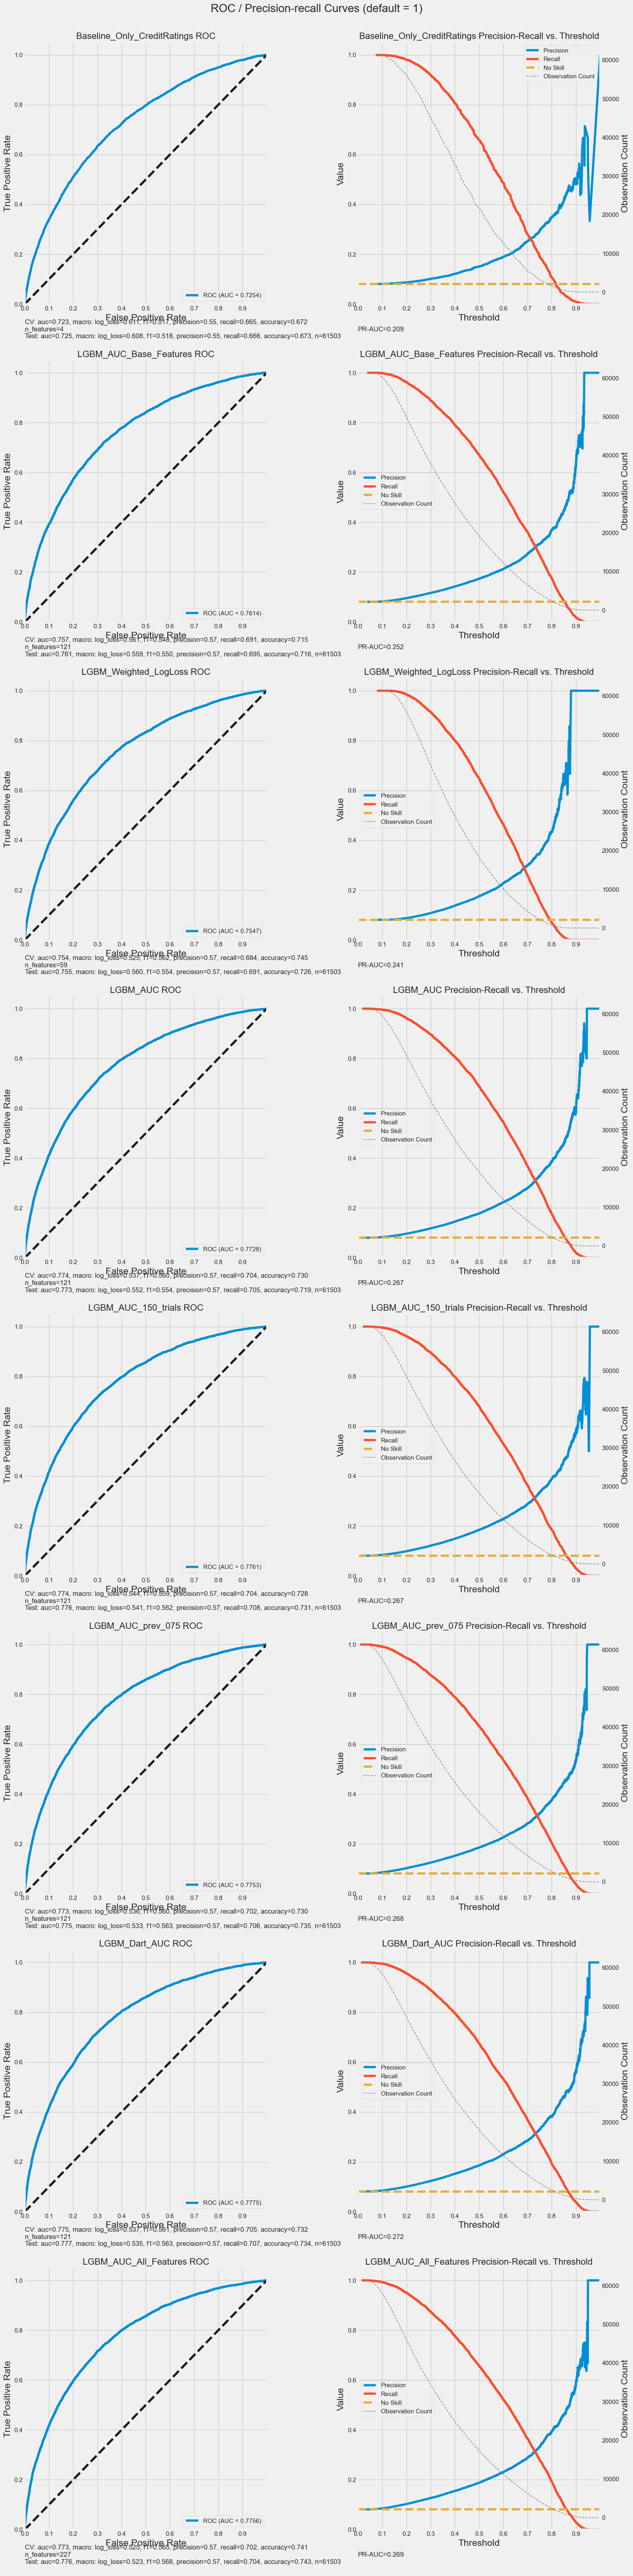

In [8]:
if len(cv_results_all_models) < 2:
    cv_results_all_models["_DUMMY"] = cv_results_all_models[list(cv_results_all_models.keys())[0]]
importlib.reload(graph)
first_model = list(cv_results_all_models.keys())[0]
graph.roc_precision_recal_grid_plot(cv_results_all_models, show_observation_count=True)

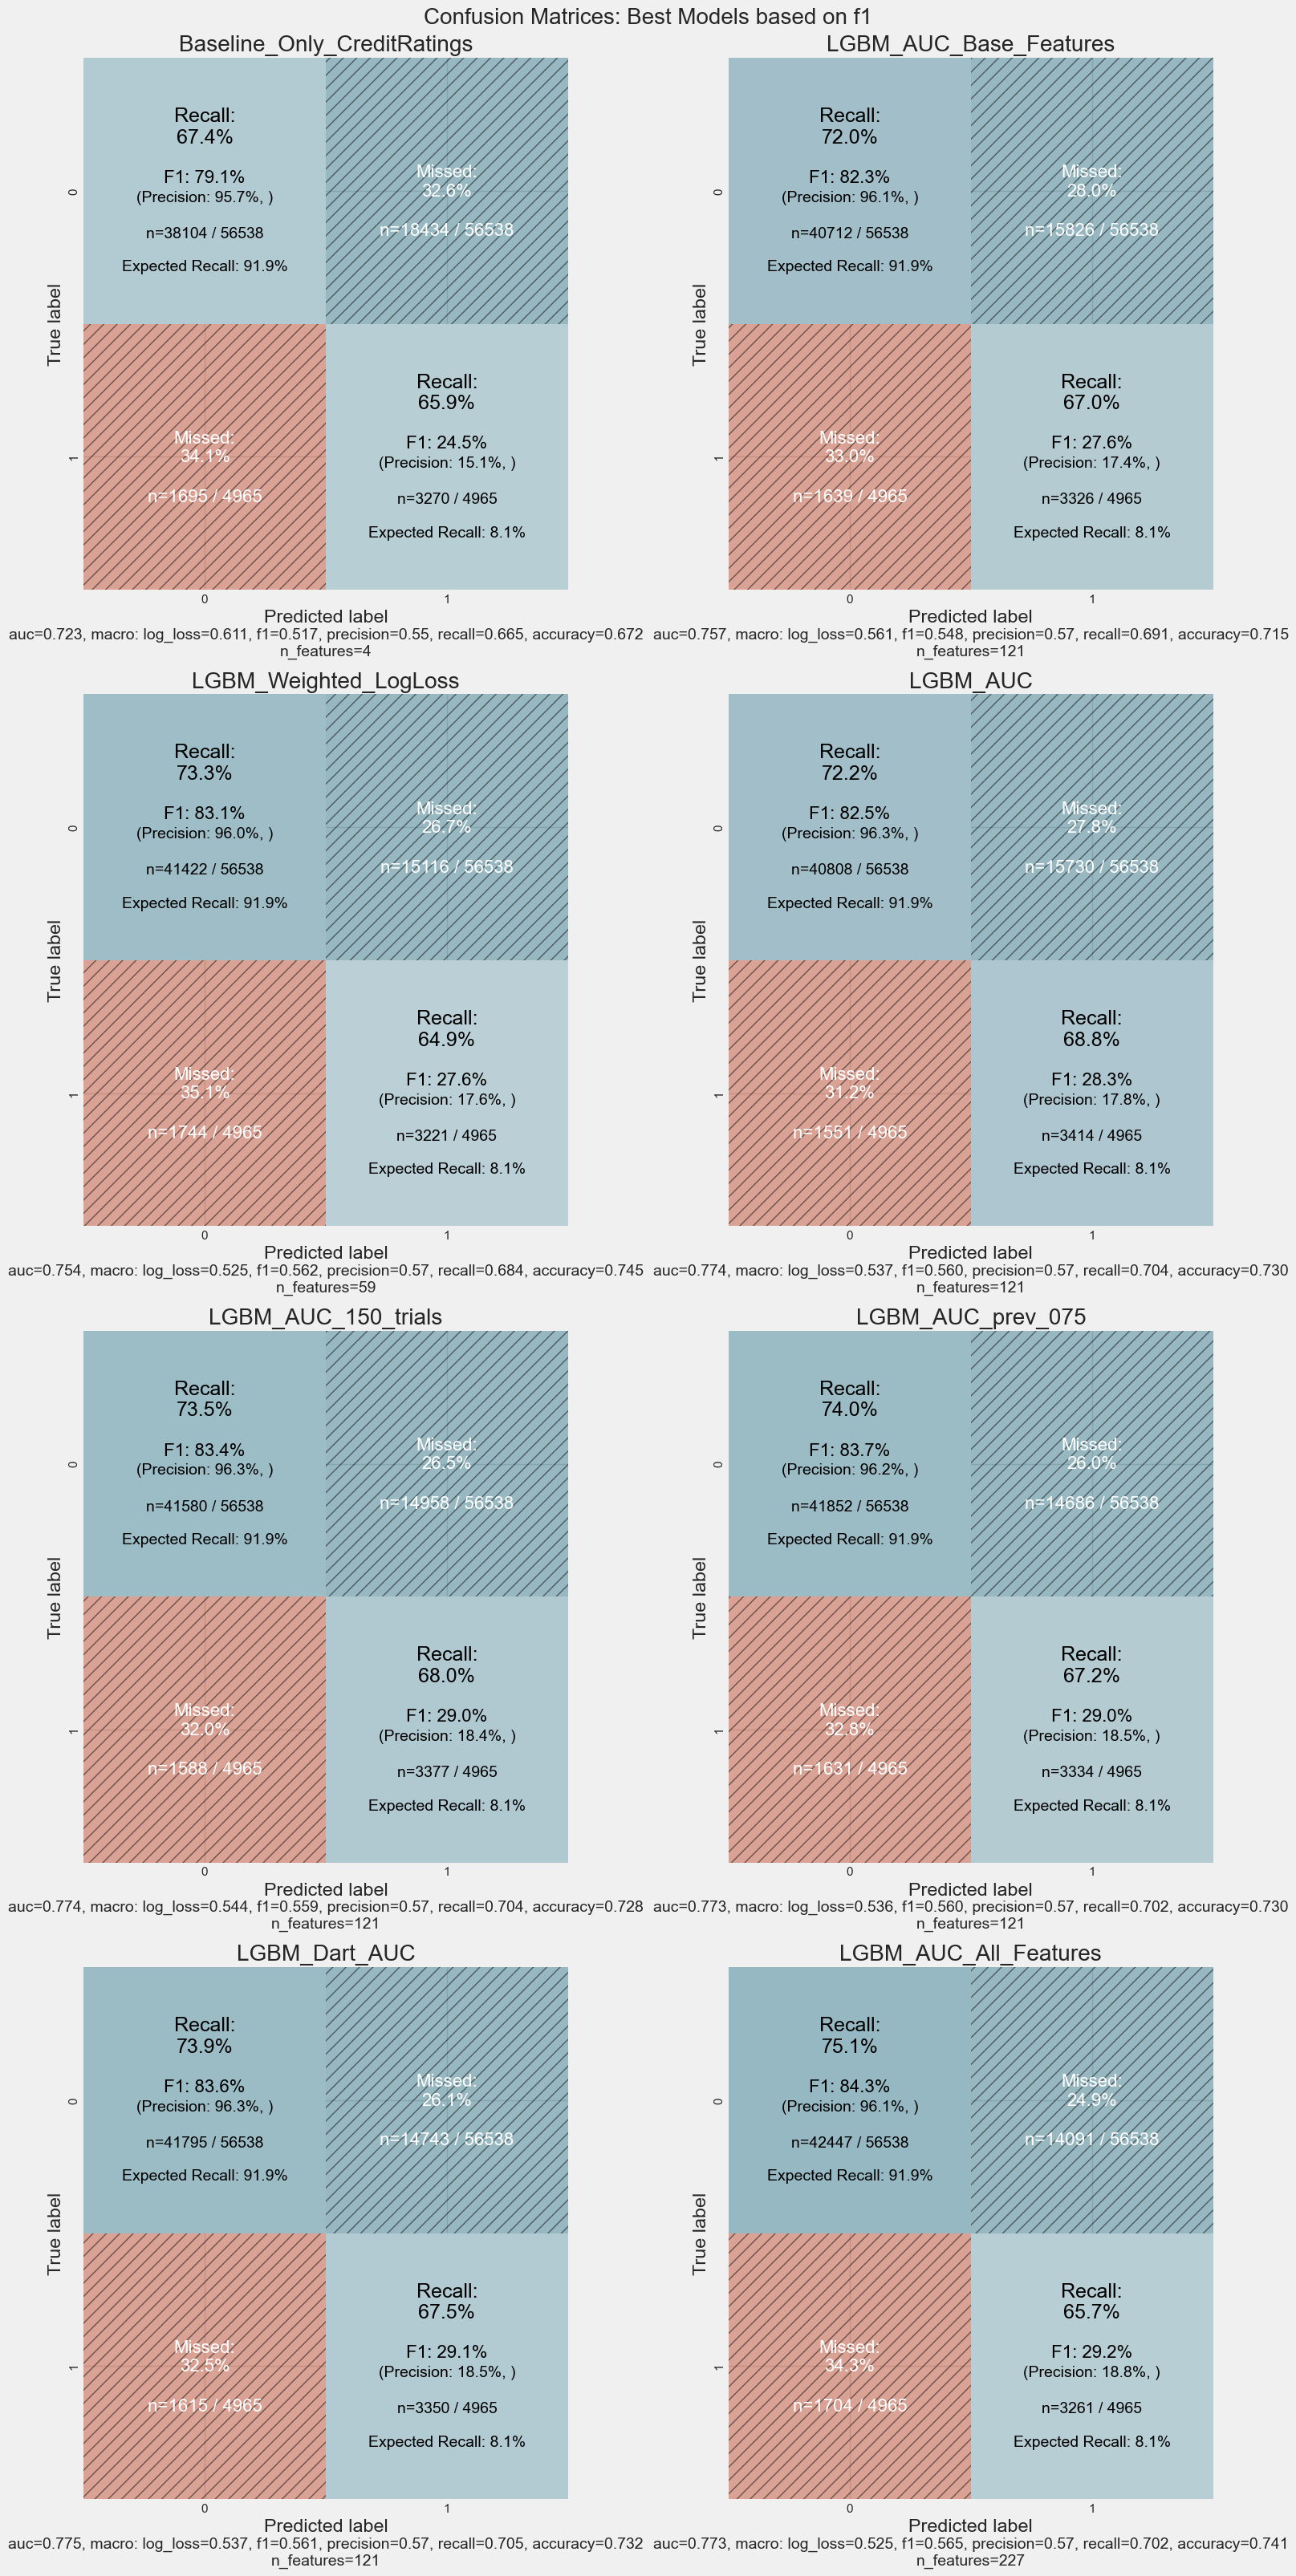

In [9]:
importlib.reload(graph)

n = len(cv_results_all_models)
columns = 2
rows = (n + 1) // columns
height = 8
width = height * columns

fig, axes = plt.subplots(
    rows, columns, figsize=(width, height * rows), constrained_layout=True
)
plt.suptitle("Confusion Matrices: Best Models based on f1", fontsize=20)

axes_flat = axes.flatten()
for i, model_key in enumerate(cv_results_all_models.keys()):
    graph.confusion_matrix_plot_v2(
        cv_results_all_models[model_key].cm_data,
        title=model_key,
        annotations=graph.make_annotations(cv_results_all_models[model_key].cv_metrics,
                                           n_feats=len(cv_results_all_models[model_key].cm_data.x_test.columns)),
        ax=axes_flat[i],
    )

# Hide any unused axes
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.show()

In [10]:
# importlib.reload(stats_utils)
# importlib.reload(graph)
# 
# for model_key in cv_results_all_models.keys():
#     if "Baseline" in model_key:
#         continue
#     model_config = cv_results_all_models[model_key]
#     feature_importances = stats_utils.get_model_feature_importances(
#         model_config, features_matrix
#     )
# 
#     graph.render_feature_importances_chart(
#         feature_importances=feature_importances,
#         title=f"{model_key} Importances",
#         top_n=50
#     )
#     if VERBOSE:
#         display(feature_importances)

In [11]:
# cv_results_all_models.keys()

In [ ]:
from shared import pipeline

# from shared import pipeline

# 


In [32]:
models_data = [
    # {'name': 'Model A', 'y_test': y_test_A, 'prob_pos': prob_pos_A},
    # {'name': 'Model B', 'y_test': y_test, 'prob_pos': prob_pos}
]

for k, model_config in results_all_models.items():
    target_model_config = results_all_models[k]
    features_matrix = target_model_config[0].model_pipeline_config.load_data(
        loader_function=feature_builder_v2.load_datasets_and_prepare_features)
    # 
    features_all, labels_all = pipeline._get_features_labels(features_matrix)
    X_train, X_test, y_train, y_test = pipeline.get_deterministic_train_test_split(
        features_all, labels_all
    )

    X_train = X_train.drop(columns=["TARGET"])
    X_test = X_test.drop(columns=["TARGET"])

    model = target_model_config[1].test_data.test_model.named_steps["model"]

    prob_pos = model.predict_proba(X_test)[:, 1]

    models_data.append(dict(
        name=k,
        y_test=y_test,
        prob_pos=prob_pos
    ))


Full DS size: 307511
Full DS size: 307511
drop drop_cols_post_proc: 121
after drop_cols_post_proc: 59
Full DS size: 307511


C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511


C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511


C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511


C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511


C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
Full DS size: 307511


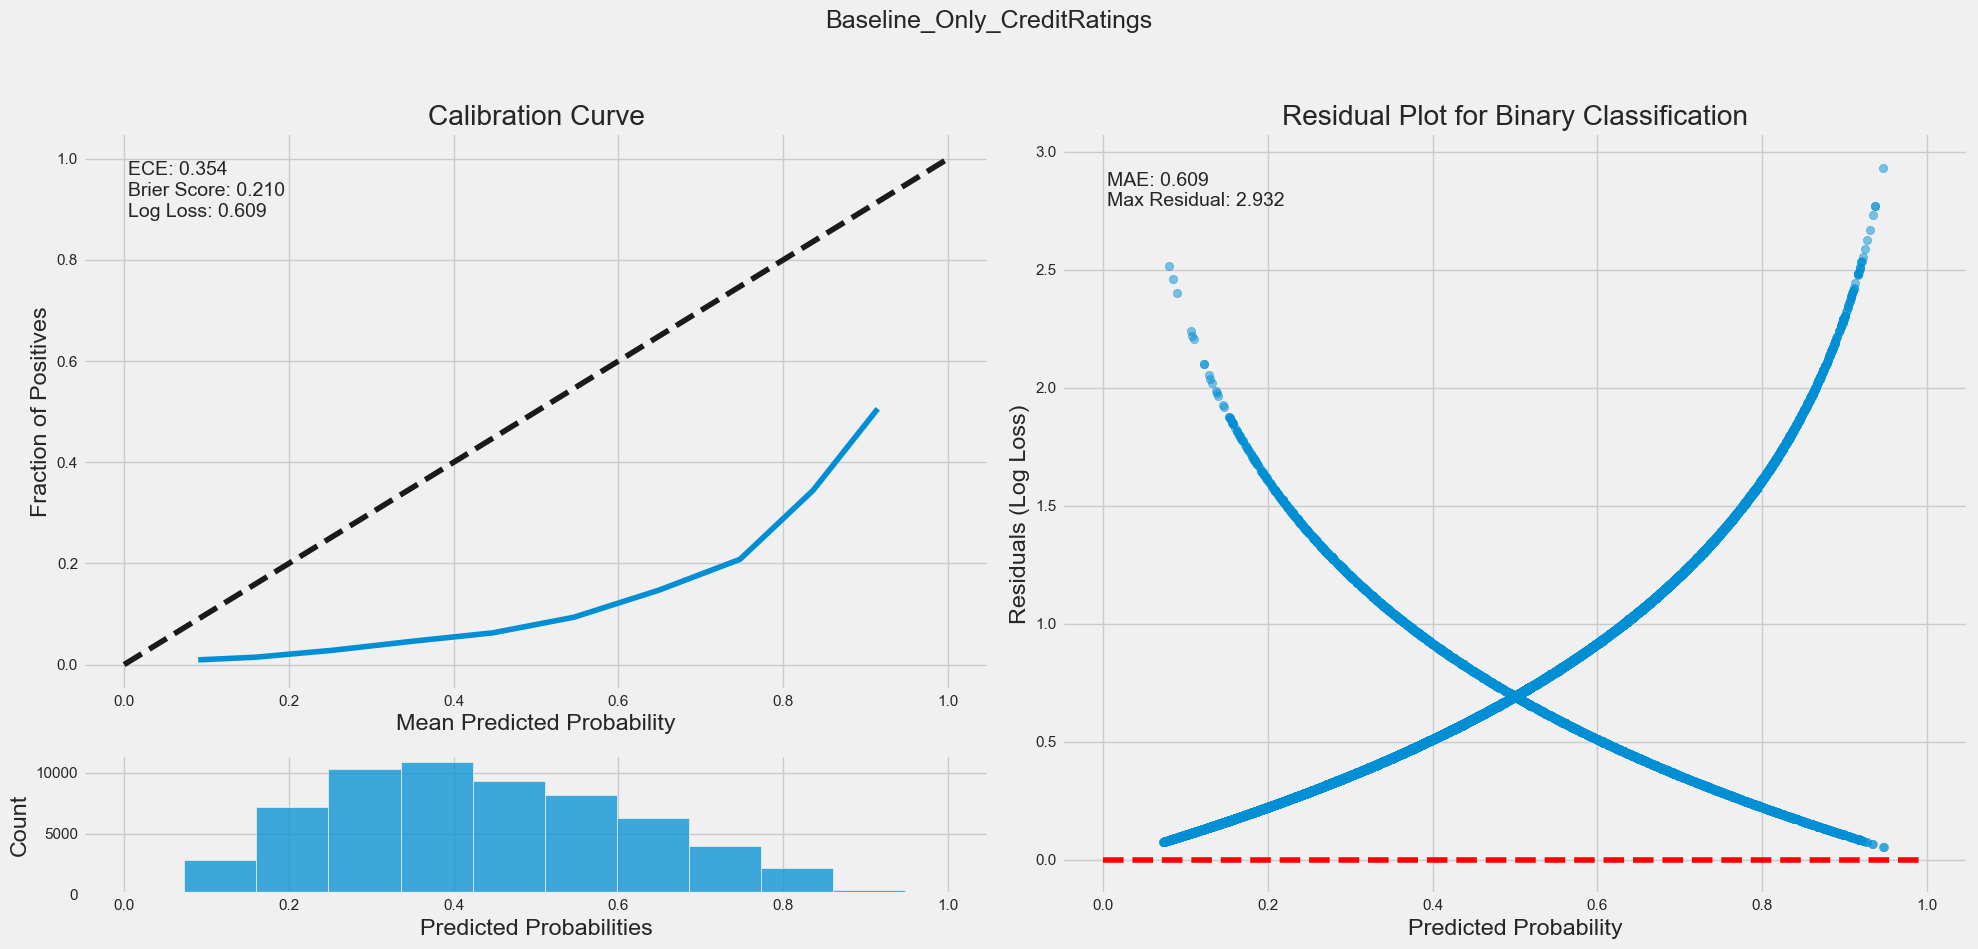

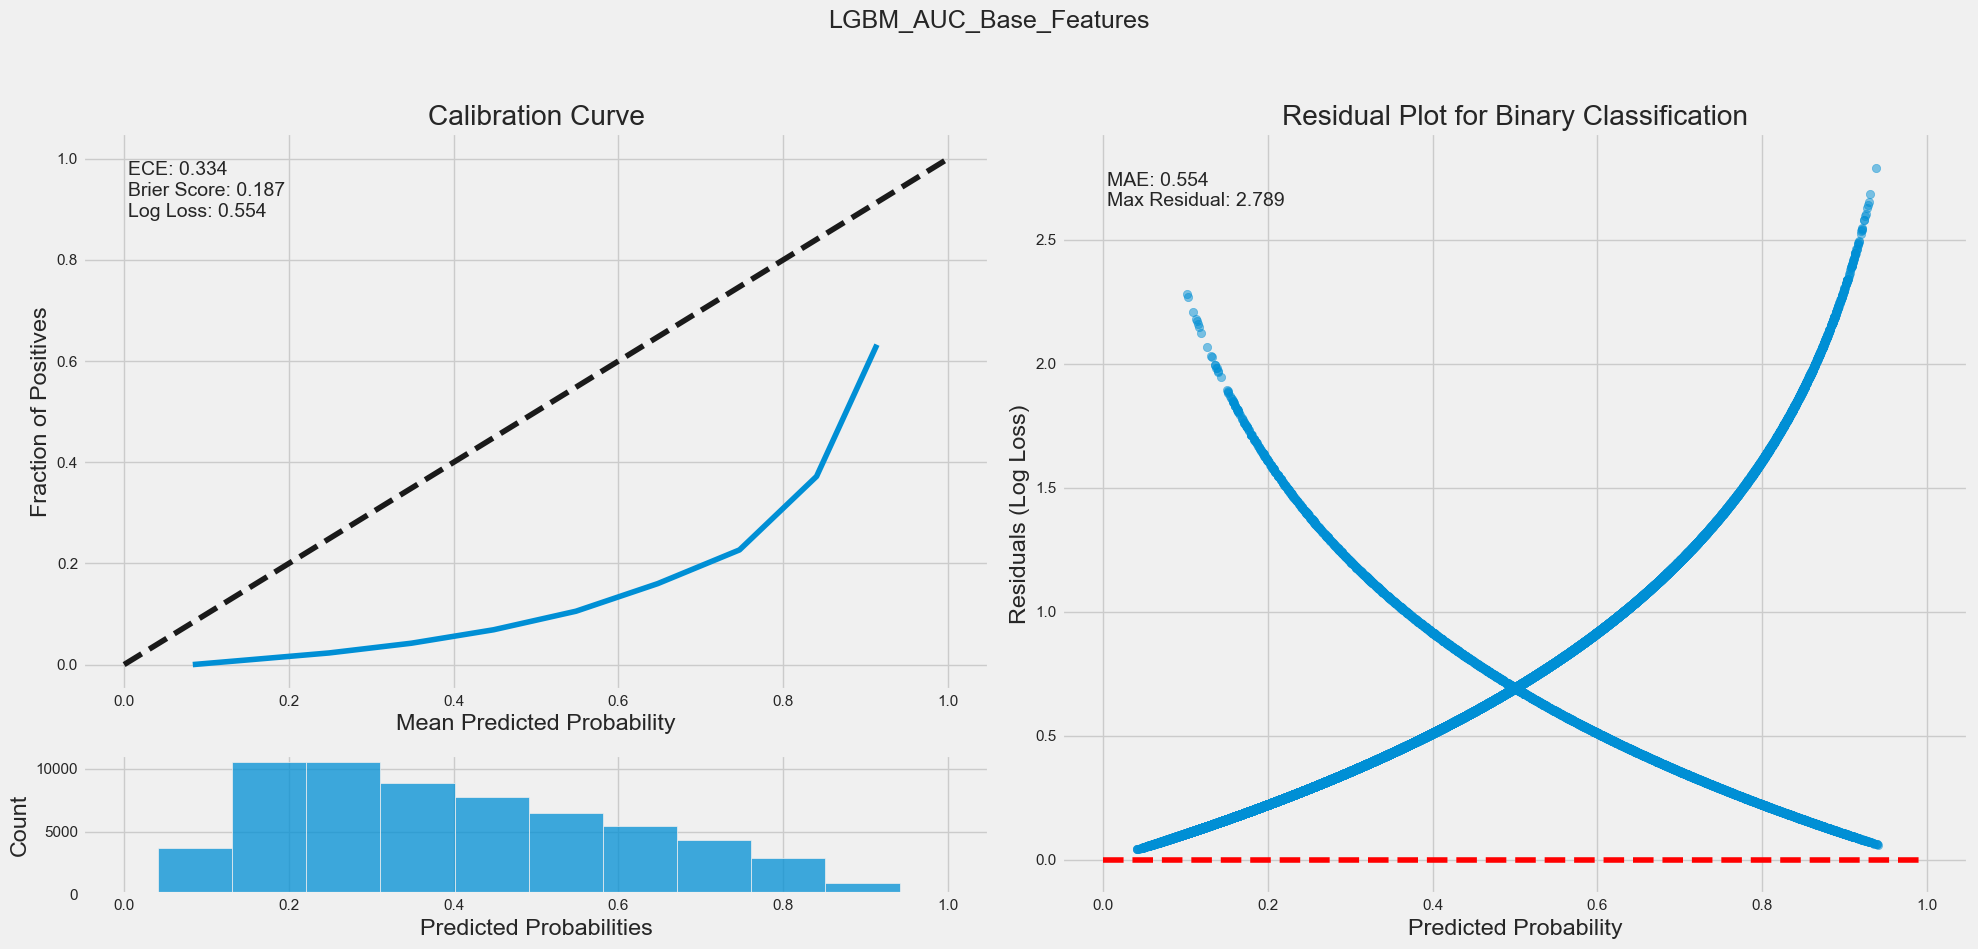

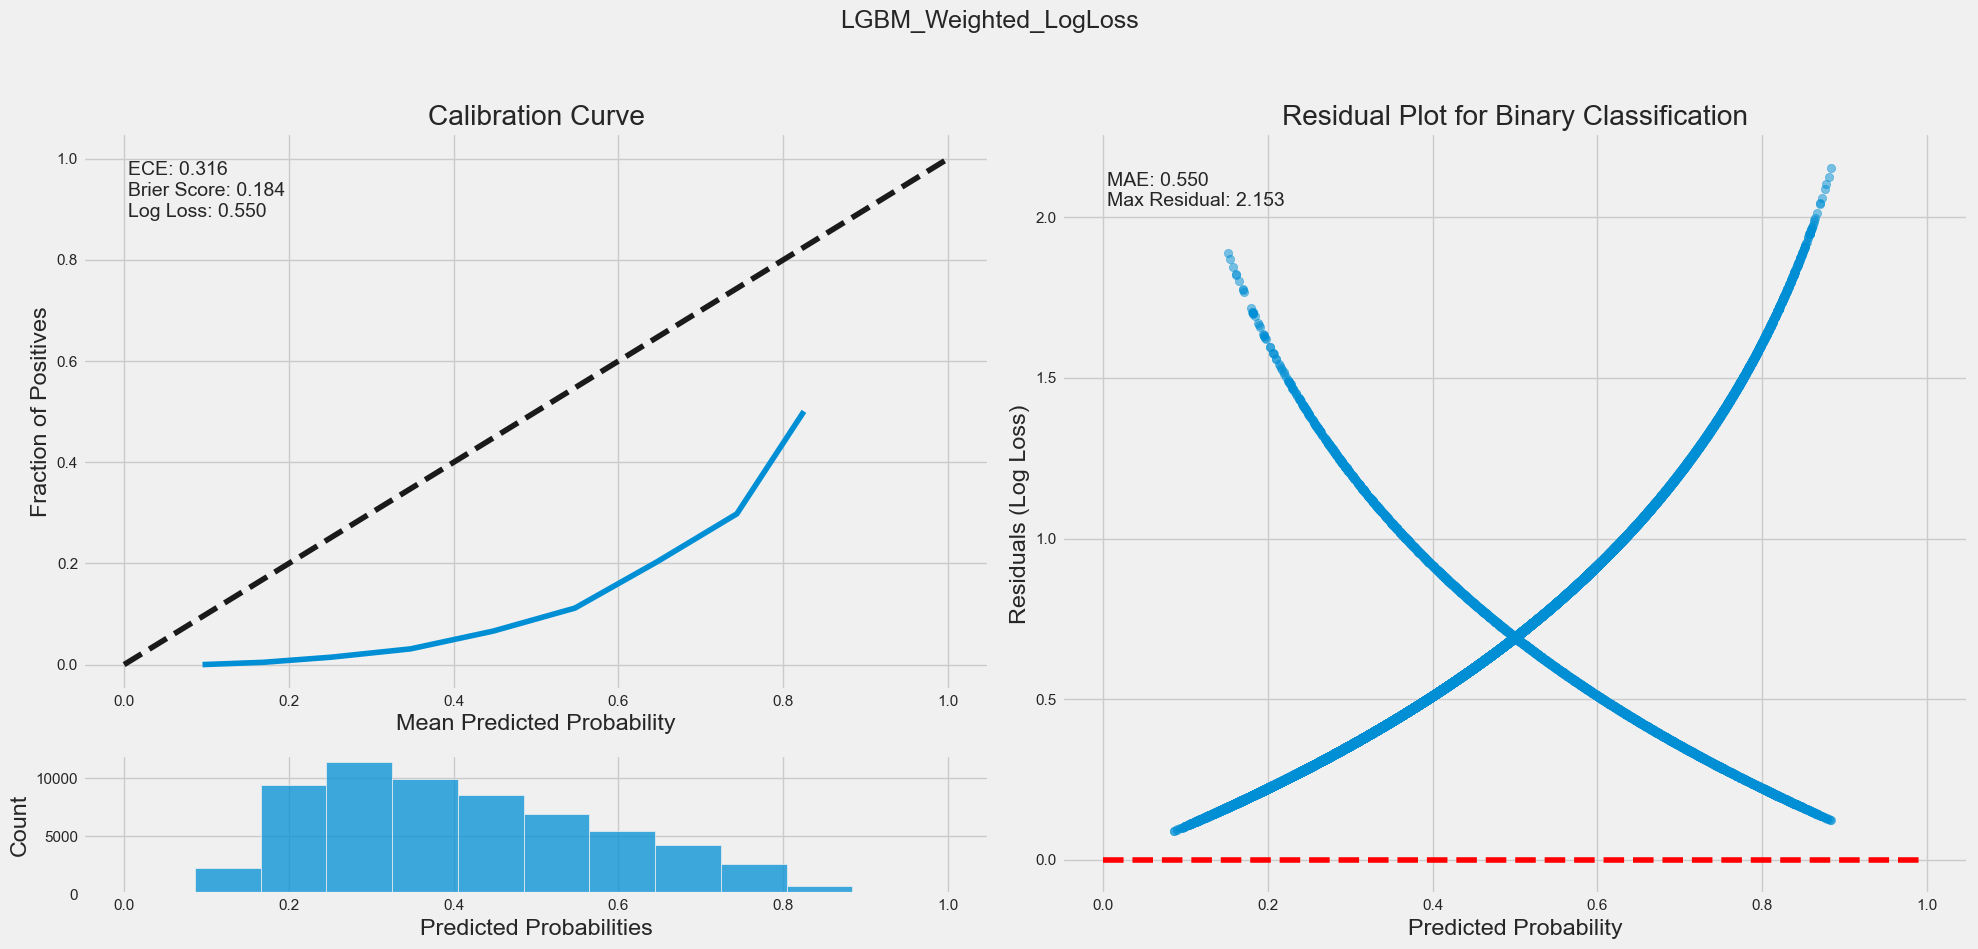

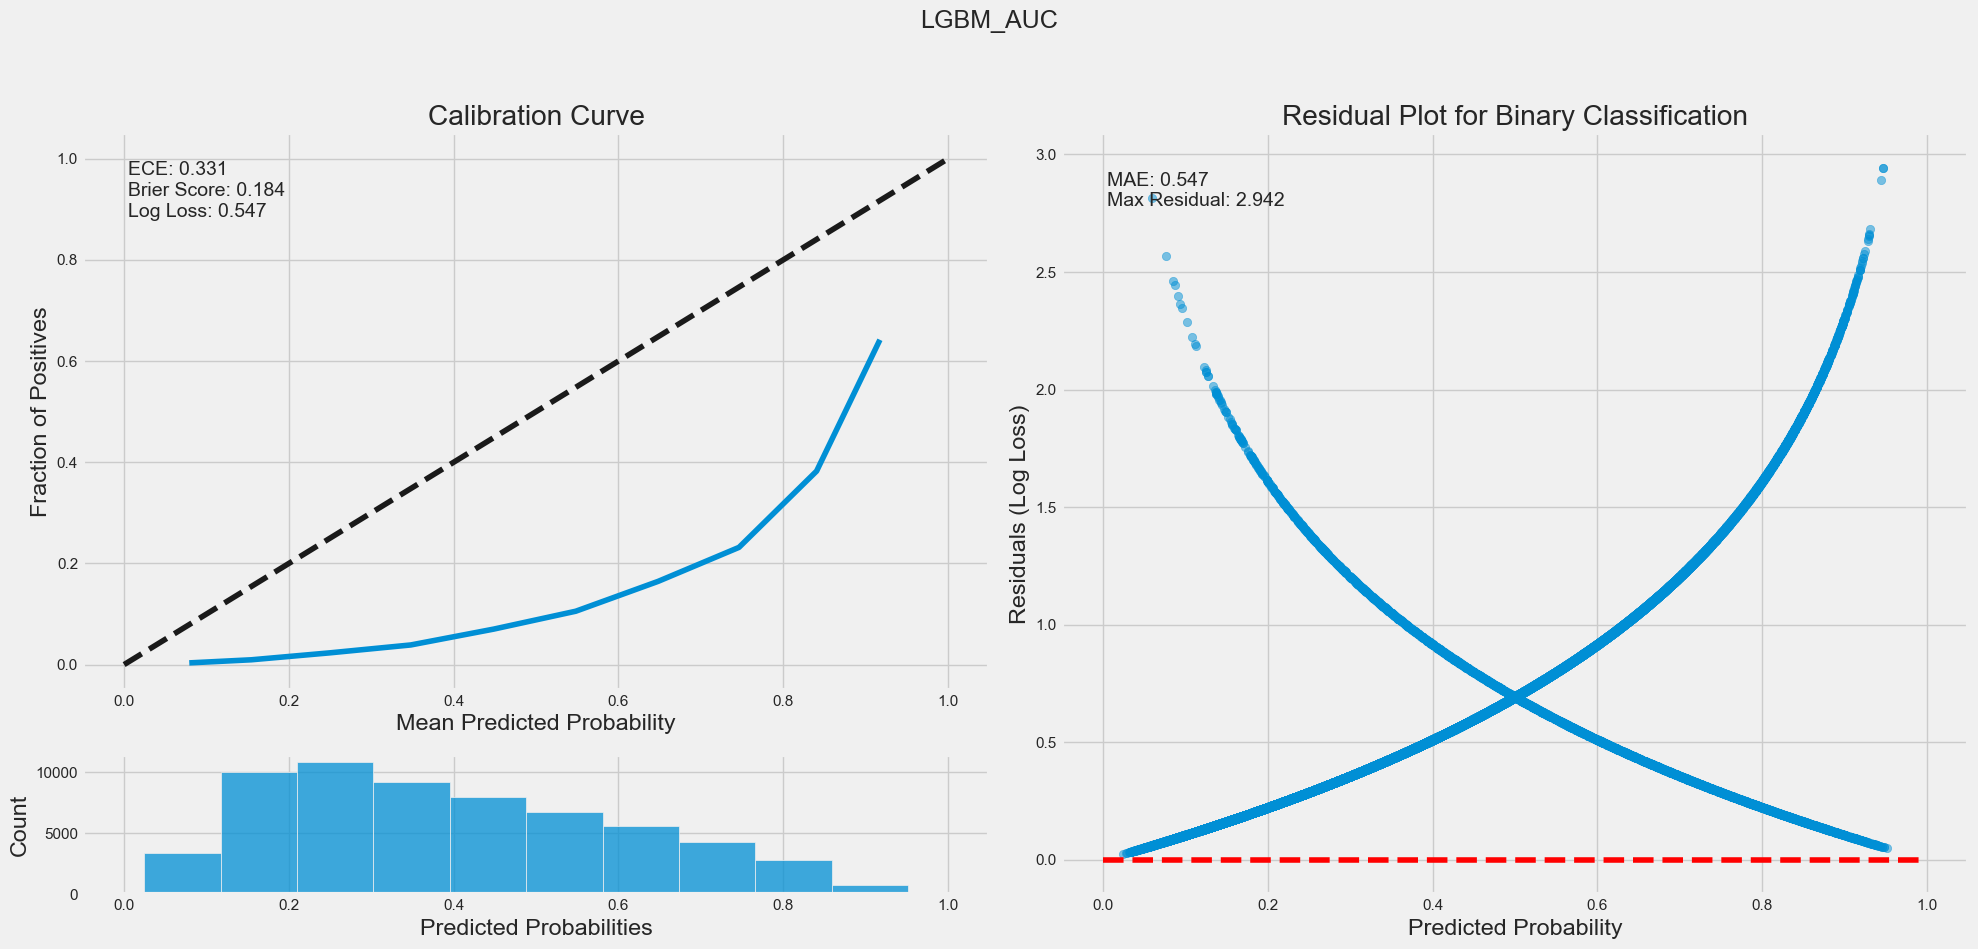

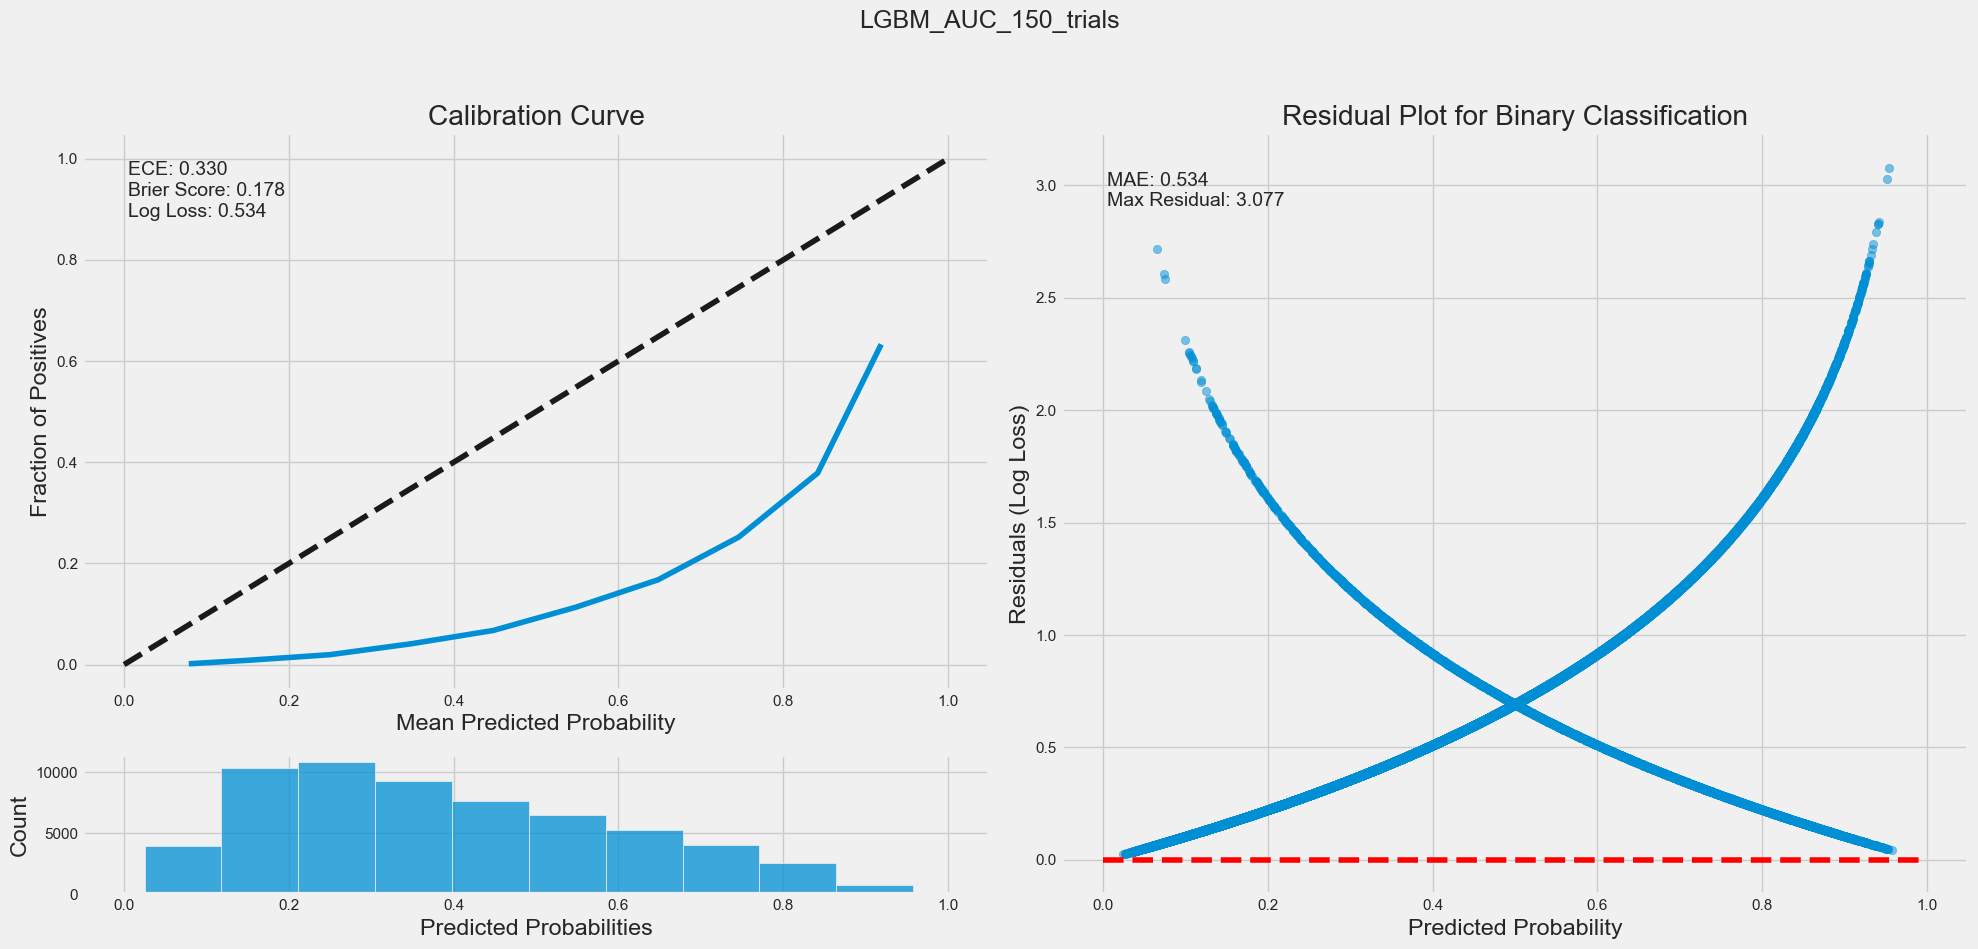

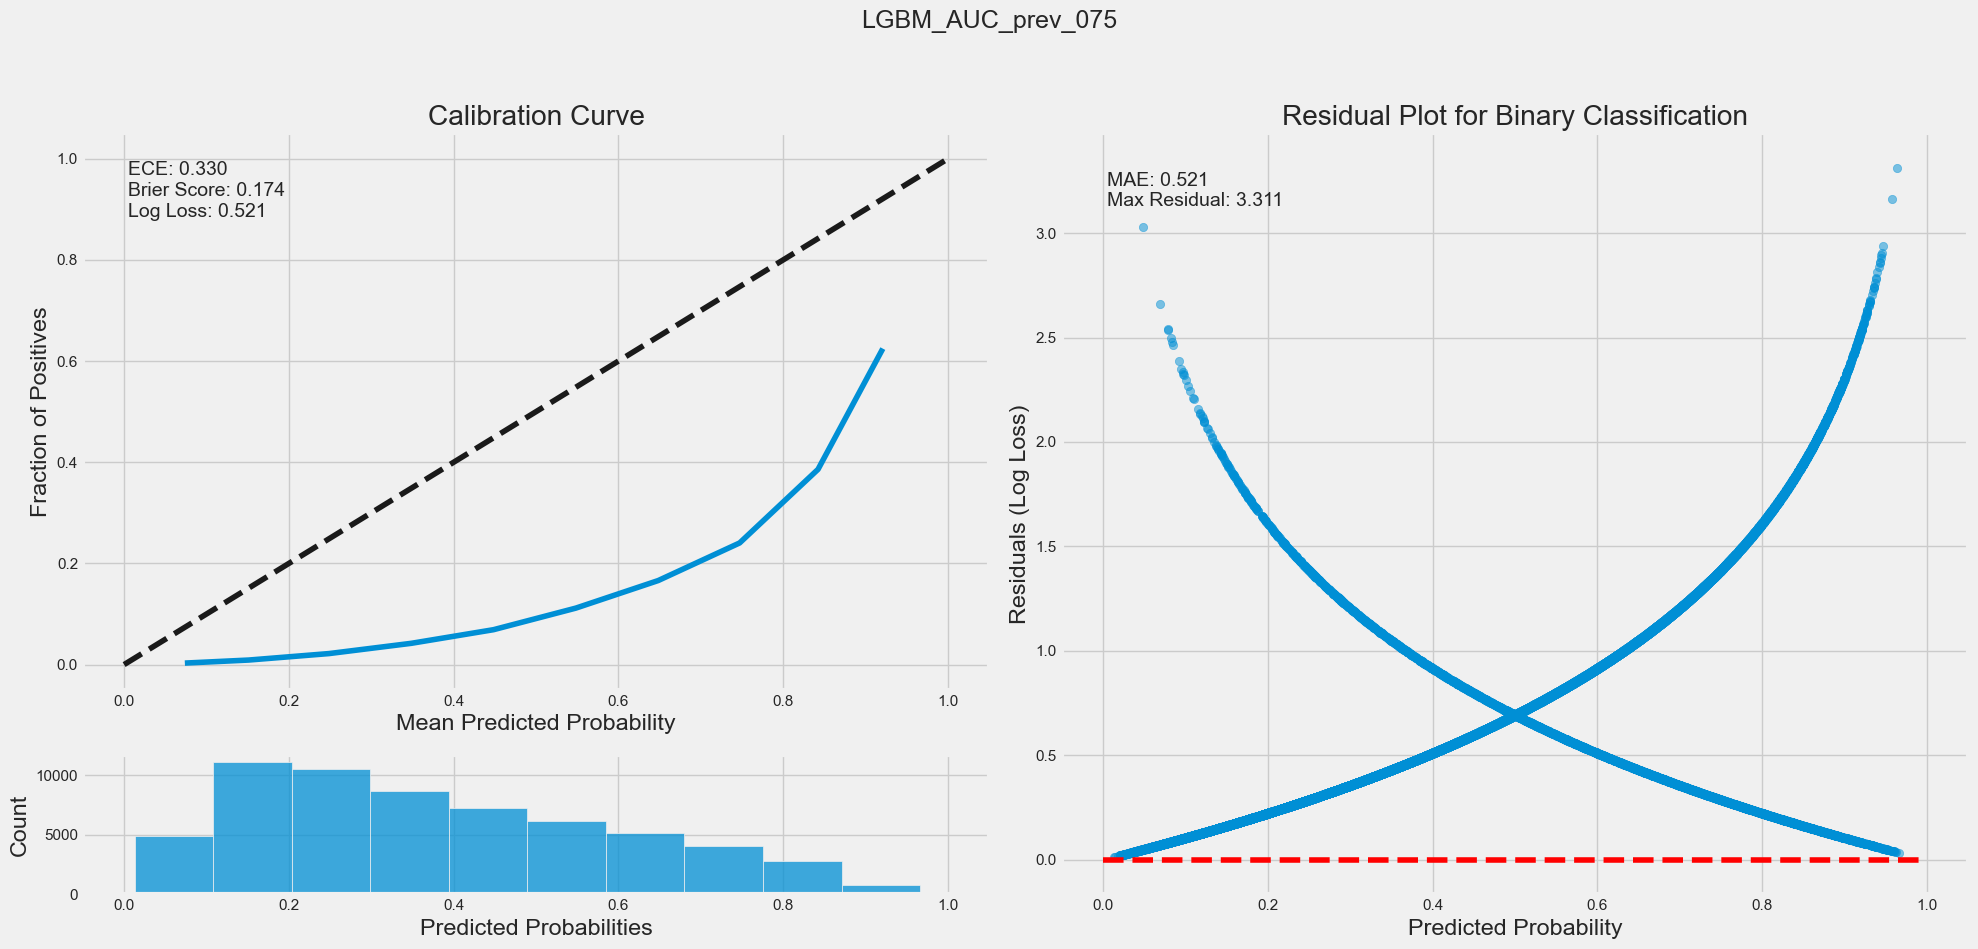

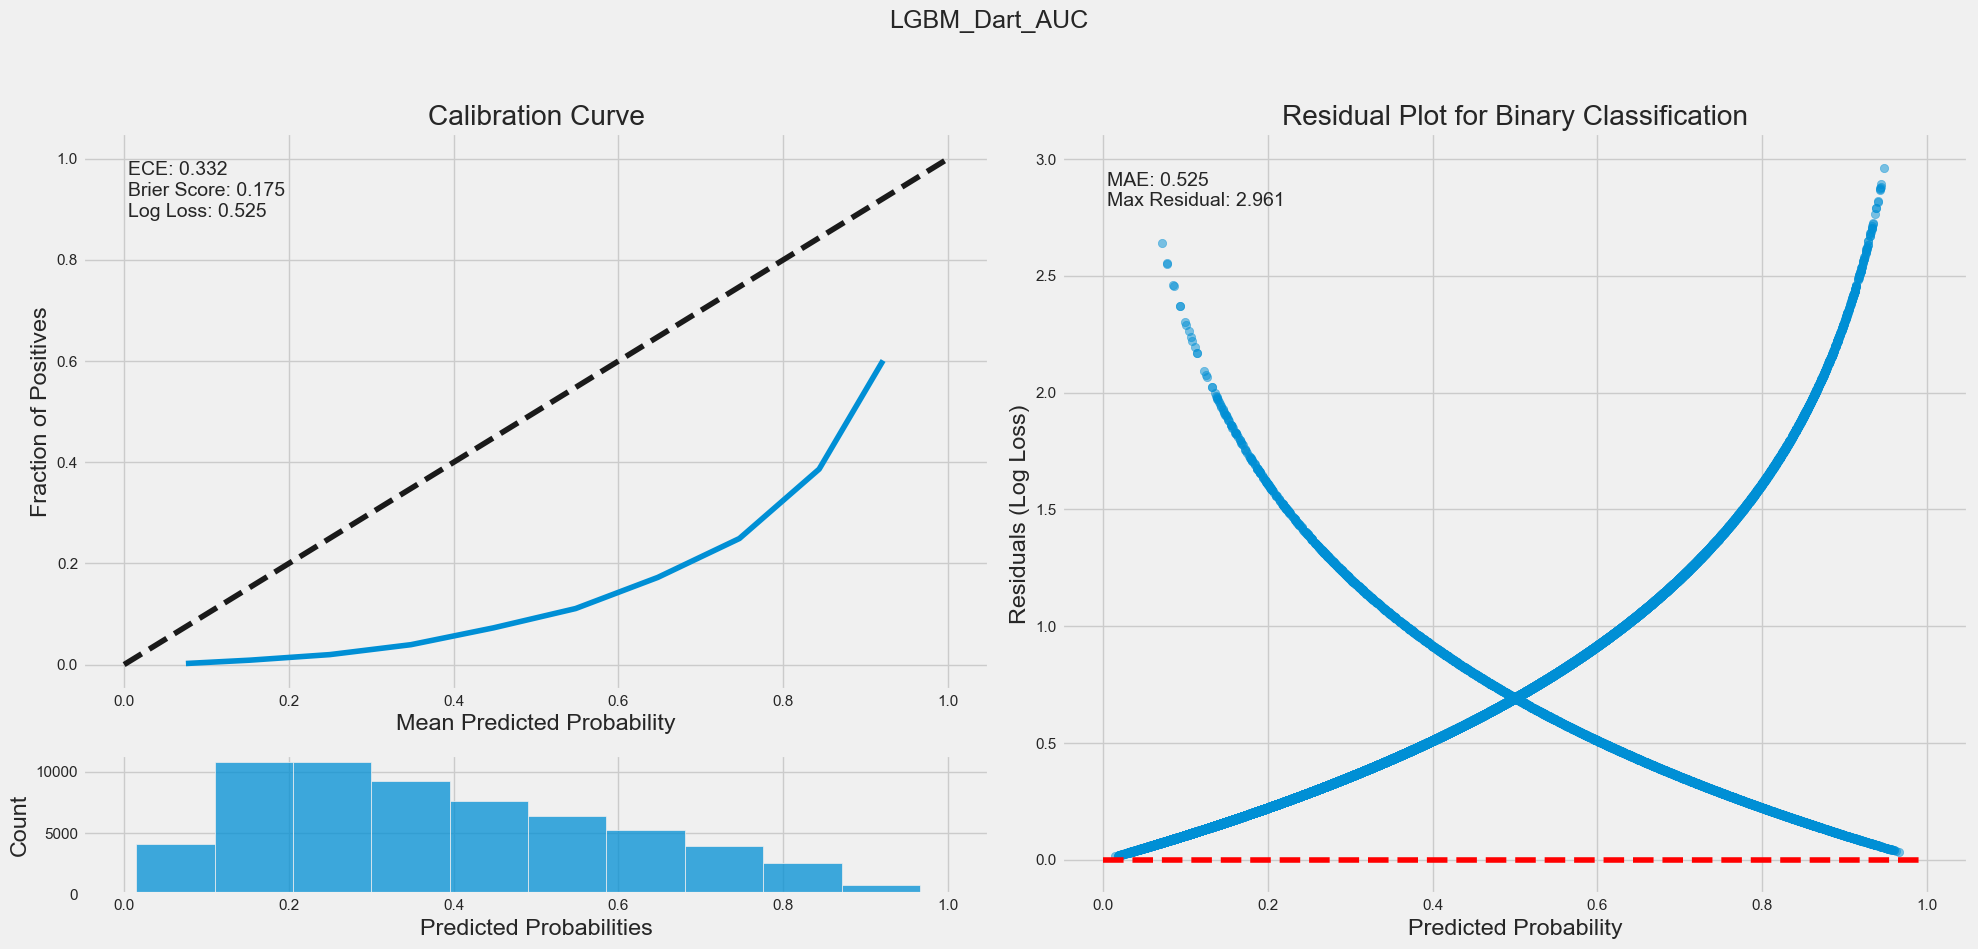

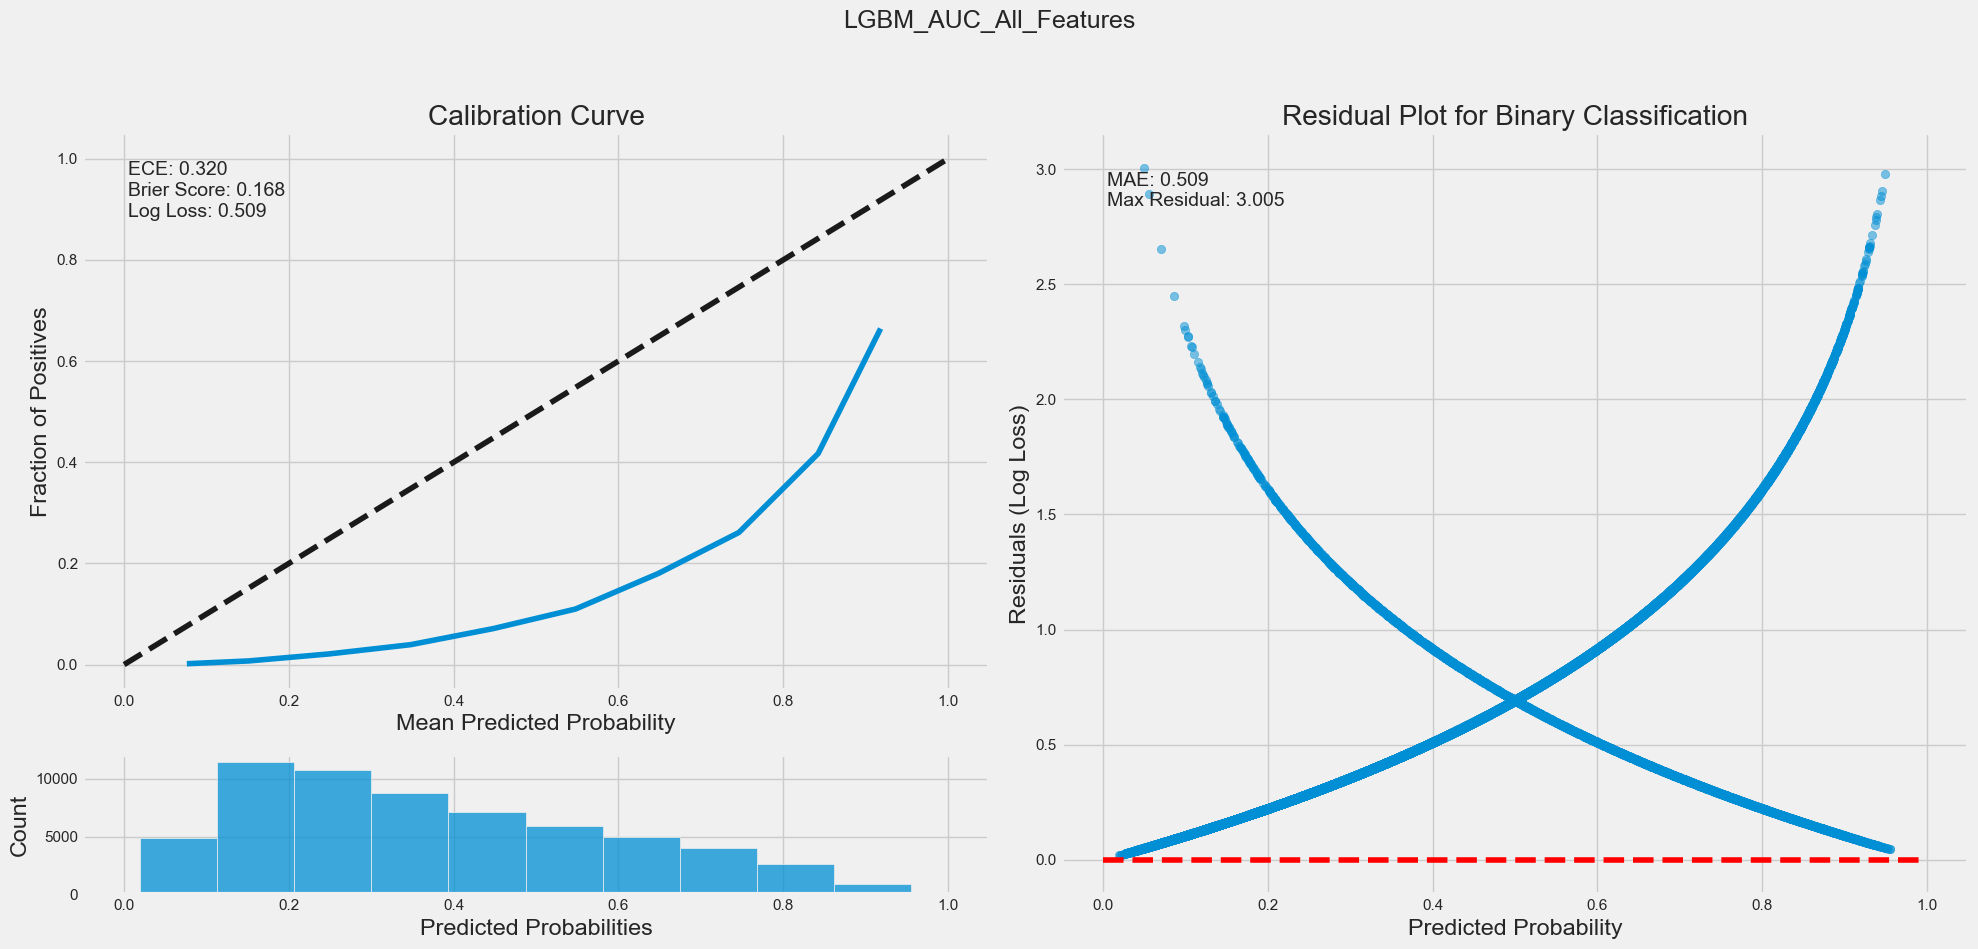

In [35]:
from matplotlib import gridspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss


def plot_calibration_plot(ax0, ax1, y_test, prob_pos, n_bins=10):
    true_prob, pred_prob = calibration_curve(y_test, prob_pos, n_bins=n_bins)
    calibration_data = pd.DataFrame({
        'Predicted Probability': pred_prob,
        'True Probability': true_prob
    })

    # Calibration curve
    sns.lineplot(data=calibration_data, x='Predicted Probability', y='True Probability', ax=ax0)
    ax0.plot([0, 1], [0, 1], 'k--')
    ax0.set_title('Calibration Curve')
    ax0.set_xlabel('Mean Predicted Probability')
    ax0.set_ylabel('Fraction of Positives')

    # Annotations for ECE, Brier Score, and Log Loss
    ece = np.mean(np.abs(pred_prob - true_prob))
    brier_score = brier_score_loss(y_test, prob_pos)
    logloss = log_loss(y_test, prob_pos)
    ax0.annotate(f'ECE: {ece:.3f}\nBrier Score: {brier_score:.3f}\nLog Loss: {logloss:.3f}', xy=(0.05, 0.95),
                 xycoords='axes fraction', verticalalignment='top')

    # Histogram
    sns.histplot(prob_pos, bins=10, ax=ax1)
    ax1.set_xlabel('Predicted Probabilities')
    ax1.set_ylabel('Count')


def plot_residuals(ax, y_test, prob_pos):
    residuals = np.where(y_test == 1, -np.log(prob_pos), -np.log(1 - prob_pos))
    ax.scatter(prob_pos, residuals, alpha=0.5)
    ax.hlines(y=0, xmin=0, xmax=1, color='red', linestyles='--')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Residuals (Log Loss)')
    ax.set_title('Residual Plot for Binary Classification')

    # Annotations for MAE and Maximum Residual
    mae = np.mean(np.abs(residuals))
    max_residual = np.max(np.abs(residuals))
    ax.annotate(f'MAE: {mae:.3f}\nMax Residual: {max_residual:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top')


def plot_model_comparisons(models_data):
    for model in models_data:
        fig = plt.figure(figsize=(20, 10))
        gs = gridspec.GridSpec(2, 2, height_ratios=[4, 1], width_ratios=[1, 1])

        # Calibration curve and histogram
        ax0 = plt.subplot(gs[0, 0])
        ax1 = plt.subplot(gs[1, 0], sharex=ax0)
        plot_calibration_plot(ax0, ax1, model['y_test'], model['prob_pos'])

        # Residuals plot
        ax2 = plt.subplot(gs[:, 1])
        plot_residuals(ax2, model['y_test'], model['prob_pos'])

        plt.suptitle(f"{model['name']}", fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for title
        plt.show()


# Example usage:
# models_data = [
#     # {'name': 'Model A', 'y_test': y_test_A, 'prob_pos': prob_pos_A},
#     {'name': 'Model B', 'y_test': y_test, 'prob_pos': prob_pos}
# ]
plot_model_comparisons(models_data)


The **calibration curve**, also known as a reliability diagram, is a graphical representation used to evaluate the accuracy of predicted probabilities in classification models. It specifically checks how well the predicted probabilities of a model match the actual outcomes.

The ideal calibration curve is a straight line at a 45-degree angle from the bottom left to the top right of the plot. This line, often called the "line of perfect calibration," indicates that the model's predictions are perfectly calibrated. If your model predicts a class with 70% probability, then 70% of the cases that are predicted as such should indeed belong to that class.

Common Patterns and Their Interpretations:
Perfect Calibration:

The points lie on the diagonal line from (0,0) to (1,1).
Example: If a model predicts an event with 30% probability, then in the long run, that event occurs about 30% of the time when predicted at this probability.
Underconfidence:

The curve lies above the diagonal line.
The model's probabilities are lower than the true likelihood of the event. For instance, if events the model predicts to happen 60% of the time actually happen 80% of the time, the model is underconfident.
Overconfidence:

The curve lies below the diagonal line.
The model predicts higher probabilities than what is true. If a prediction of 80% only happens 60% of the time, the model is overconfident.

*Expected Calibration Error (ECE)*: This measures the average difference between the predicted probabilities and the actual outcomes. Lower values indicate better calibration.

*Brier Score*: Measures the mean squared difference between the predicted probability and the actual outcome. It is a good measure of the accuracy and calibration of the predictions.




**Residual** Plots show the difference between observed and predicted probabilities. Helps in checking the assumption of homoscedasticity. Ideally, residuals should be randomly dispersed around the central line, and patterns suggest model inadequacies.


homoscedasticity


Based on the chart we see these potential problems:
Probability Estimates are Polarized:

The cup-like pattern at the top suggests the model is very confident (probabilities close to 0 or 1) about certain instances but is incorrect, as these points have higher residuals.
The bottom lines being straighter and closer to zero indicate that for a range of predicted probabilities, the residuals are consistently low, which means the model performs well in that range.

Model Overconfidence:

The residuals are larger for predictions near 0 or 1 because the log loss penalizes confident incorrect predictions more harshly than less confident ones.
This overconfidence is often characteristic of models that are not well-calibrated and could benefit from probability calibration techniques.

Class Imbalance:

This pattern can sometimes emerge from class imbalance if the model is better at predicting the majority class and frequently mispredicts the minority class with high confidence.

Non-linearity in Feature Space:

The curving pattern could also be a sign that the model is not capturing some non-linear relationships between features and the outcome. This might suggest that feature engineering or a more sophisticated model could be helpful.

*Mean Absolute Error (MAE)* of Residuals: This is the average of the absolute values of the residuals. It gives an idea of the average magnitude of the prediction errors.
Annotation: Indicating MAE on the residual plot can help assess the typical error magnitude in a more intuitive way than just viewing the spread of residuals.

*Maximum Residual*: The maximum value among the residuals can indicate the worst-case scenario for your predictions.
Annotation: Marking the maximum residual can alert users to the worst errors the model could make.



In [42]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [36]:
shap.summary_plot(shap_values[1], X_test)

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [43]:
import numpy as np

# Assuming shap_values is a list of SHAP values for a multi-class model, or a numpy array for a binary model
if isinstance(shap_values, list):  # Multi-class scenario
    # Calculate the mean absolute SHAP values for each feature across all classes
    shap_abs_mean = np.abs(np.concatenate(shap_values, axis=0)).mean(axis=0)
else:  # Binary classification or regression
    shap_abs_mean = np.abs(shap_values).mean(axis=0)

# Creating a DataFrame with feature names and their corresponding mean absolute SHAP values
feature_importances_df = pd.DataFrame(list(zip(X_test.columns, shap_abs_mean)),
                                      columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Display the DataFrame
# display(feature_importances_df)

low_imp = feature_importances_df[feature_importances_df["Importance"] < 0.002]
list(low_imp["Feature"])

['FlagDocument18',
 'MinbureauamtAnnuity',
 'LandareaMedi',
 'CntFamMembers',
 'LivingapartmentsMedi',
 'BasementareaMedi',
 'PrevContractStatusRefusedCount',
 'LivingareaMode',
 'EntrancesAvg',
 'NonlivingapartmentsMode',
 'YearsBuildMode',
 'EntrancesMode',
 'LivingapartmentsAvg',
 'PrevLastLoanProductType',
 'CommonareaMode',
 'ElevatorsMedi',
 'PrevCodeRejectReasonHcCount',
 'ElevatorsAvg',
 'YearsBuildAvg',
 'PrevPortfolioXnaCount',
 'EntrancesMedi',
 'YearsBuildMedi',
 'LivingapartmentsMode',
 'MaxbureauamtCreditSumOverdue',
 'RegCityNotWorkCity',
 'PrevRefusedLoans',
 'MeanbureaudaysEnddateFact',
 'NonlivingareaMedi',
 'MaxbureauamtAnnuity',
 'CommonareaAvg',
 'FloorsminAvg',
 'PrevTotalLoans',
 'PrevLastLoanPortfolio',
 'NonlivingareaAvg',
 'PrevPortfolioCashCount',
 'PrevCodeRejectReasonScoCount',
 'PrevLastLoanPurpose',
 'PrevAvgNflagInsuredOnApproval',
 'CntChildren',
 'MeanbureaucntCreditProlong',
 'PrevTotalPreviousLoans',
 'PrevContractStatusCanceledCount',
 'CommonareaMe

In [38]:
high_imp = feature_importances_df[feature_importances_df["Importance"] > 0.035]
list(high_imp["Feature"])
# len(list(high_imp["Feature"]))

['CntFamMembers',
 'RegionRatingClient',
 'OccupationType',
 'AmtCredit',
 'CntChildren',
 'CodeGender',
 'FlagEmail',
 'NameHousingType',
 'DaysEmployed',
 'AmtIncomeTotal',
 'NameFamilyStatus',
 'AmtGoodsPrice',
 'FlagDocument6',
 'FlagDocument19',
 'YearsBeginexpluatationMedi',
 'Def60CntSocialCircle',
 'NameTypeSuite',
 'DaysBirth',
 'LandareaMode',
 'FlagDocument12',
 'ApartmentsMedi',
 'OwnCarAge',
 'NonlivingareaAvg',
 'FloorsminMode',
 'LivingareaMode',
 'FlagEmpPhone',
 'FlagDocument9']

In [39]:
any_imp = feature_importances_df[feature_importances_df["Importance"] > 0.01]
list(any_imp["Feature"])
# len(list(any_imp["Feature"]))

['CntFamMembers',
 'RegionRatingClient',
 'OccupationType',
 'AmtCredit',
 'CntChildren',
 'CodeGender',
 'FlagEmail',
 'NameHousingType',
 'DaysEmployed',
 'AmtIncomeTotal',
 'NameFamilyStatus',
 'AmtGoodsPrice',
 'FlagDocument6',
 'FlagDocument19',
 'YearsBeginexpluatationMedi',
 'Def60CntSocialCircle',
 'NameTypeSuite',
 'DaysBirth',
 'LandareaMode',
 'FlagDocument12',
 'ApartmentsMedi',
 'OwnCarAge',
 'NonlivingareaAvg',
 'FloorsminMode',
 'LivingareaMode',
 'FlagEmpPhone',
 'FlagDocument9',
 'CommonareaMedi',
 'AmtReqCreditBureauWeek',
 'ApartmentsMode',
 'TotalareaMode',
 'FlagOwnRealty',
 'LivingapartmentsMedi',
 'ElevatorsMode',
 'FlagDocument14',
 'FlagWorkPhone',
 'FlagDocument7',
 'FlagDocument16',
 'NonlivingapartmentsAvg',
 'BasementareaMedi',
 'FloorsmaxMode',
 'NameEducationType',
 'DaysRegistration',
 'DaysLastPhoneChange',
 'AmtAnnuity',
 'FlagDocument2',
 'NameContractType',
 'FlagContMobile',
 'FondkapremontMode',
 'CommonareaMode',
 'RegionPopulationRelative',
 'Amt

In [44]:
import numpy as np

# Calculate absolute differences between predicted probabilities and actual values
predicted_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

absolute_differences = np.abs(predicted_probabilities - y_test)

# Create a DataFrame for easier handling
differences_df = pd.DataFrame({
    'absolute_difference': absolute_differences,
    'index': range(len(y_test))
})

# Sort by 'absolute_difference' in descending order and select the top N
N = 10
top_differences_df = differences_df.nlargest(N, 'absolute_difference')

# If you want a random sample of N from these top differences
random_sample_top_diff = top_differences_df.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility

# Get the indices of the selected samples
selected_indices = random_sample_top_diff['index'].values

# Use these indices to select instances from X_test or y_test if needed
selected_samples_X_test = X_test.iloc[selected_indices]
selected_samples_y_test = y_test.iloc[selected_indices]


In [47]:

# for i in selected_indices:
# Create the SHAP Explanation object for the selected sample
shap_explanation = shap.Explanation(values=shap_values[1],
                                    base_values=explainer.expected_value[1],
                                    data=X_test.iloc[i].values,
                                    feature_names=X_test.columns.tolist())

# Calculate predicted probability for the selected sample
predicted_probability = model.predict_proba(X_test.iloc[i:i + 1])[0, 1]

# Retrieve the actual y value for the selected sample
actual_y_value = y_test.iloc[i]

# Generate the waterfall plot
shap.plots.waterfall(shap_explanation, show=False)

# Adding a title with the sample index, actual y value, and predicted probability
plt.title(f"{i}, Actual Y Value: {actual_y_value}, Predicted Probability: {predicted_probability:.2f}")
plt.show()


IndexError: invalid index to scalar variable.

In [ ]:
cm_target_model_key = "LGBMDTuneAUC_Full_DropLowImp"
cm_target_model = cv_results_all_models[cm_target_model_key]

target_cm_data = cm_target_model.test_data
target_cm_data_sorted = target_cm_data.probabilities.sort_values(by=1).reset_index(
    drop=True
)
target_cm_data_sorted
# target_cm_data_sorted["value"] = target_cm_data.y_test

In [ ]:
prediction_data = target_cm_data.probabilities.copy()
prediction_data["value"] = target_cm_data.y_test

In [ ]:
prediction_data

In [ ]:
target_cm_data.probabilities

In the finance industry, loan grades (or credit scores) are a crucial part of risk management, helping lenders assess the creditworthiness of borrowers. These grades are typically determined based on various factors, including the borrower's credit history, income stability, debt-to-income ratio, and more. The grades reflect the estimated risk of default, and they directly influence the interest rate offered to the borrower. Commonly, loan grades are categorized from 'A' (lowest risk) to 'G' (highest risk), although the specific categories can vary by institution.

A (Lowest Risk): Below 1% default rate. Borrowers with excellent credit histories and very low risk of default.
B: 1% to 3% default rate. Borrowers with good credit histories and low risk of default.
C: 3% to 7% default rate. Borrowers with average credit histories and moderate risk of default.
D: 7% to 15% default rate. Borrowers with below-average credit histories and higher risk of default.
E: 15% to 25% default rate. Borrowers with poor credit histories and very high risk of default.
F and G (Highest Risk): Above 25% default rate. Borrowers with very poor credit histories and extremely high risk of default.



In [ ]:
# Assuming source_df_grades_summary and target_cm_data are already defined
# Sort probabilities for cumulative proportion mapping

# Define the data as a dictionary
data = {
    "index": ["A", "B", "C", "D", "E", "F", "G"],
    "Proportion": [0.12, 0.14, 0.17, 0.14286, 0.14286, 0.14286, 0.14286],
    "Loan_Status_Ratio": [1, 1, 1, 1, 1, 1, 1]
}

# Convert the dictionary to a DataFrame
source_df_grades_summary = pd.DataFrame(data)

# Set the 'index' column as the index of the DataFrame
source_df_grades_summary = source_df_grades_summary.set_index('index')

source_df_grades_summary["Cumulative"] = source_df_grades_summary["Proportion"].cumsum()
source_df_grades_summary["Cumulative"] = source_df_grades_summary["Cumulative"].clip(
    upper=1
)

sections = []

palette = sns.color_palette("YlOrRd", n_colors=len(source_df_grades_summary))

start_color = "grey"
colors = (
        [start_color] + palette + ["red"]
)  # Ensure "red" is used for the merged EFG section

i = 0
previous_cumulative = 0

# efg_weights = source_df_grades_summary.loc["E":"G", "Counts"]
# efg_risks = source_df_grades_summary.loc["E":"G", "Loan_Status_Ratio"]
# weighted_avg_risk_efg = np.average(efg_risks, weights=efg_weights)

# Find thresholds in target_cm_data that match cumulative proportions
for grade, row in source_df_grades_summary.iterrows():
    if grade == source_df_grades_summary.index[0]:
        start = 0.0
    else:
        start = target_cm_data_sorted[1].quantile(previous_cumulative)

    end = target_cm_data_sorted[1].quantile(row["Cumulative"])

    #  merge grades E, F, G
    # if grade == "E":
    #     continue
    # elif grade == "F":
    #     continue
    # elif grade == "G":
    #     label = "E-F-G Grade"
    #     color = "red"
    # else:
    if True:
        label = f"{grade} Grade"
        color = colors[i]

    # if grade == "G":
    #     description = f"Expected D. R.: {weighted_avg_risk_efg:.1%}"
    # else:
    #     description = f"Expected D. R.: {row['Loan_Status_Ratio']:.1%}"

    sections.append(
        {
            "label": label,
            "start": start,
            "end": end,
            "color": color,
            "description": "",
        }
    )
    if grade != "G":
        i += 1
    previous_cumulative = row["Cumulative"]
sections[-1]["end"] = 1.35
# sections




In [ ]:
import numpy as np
import pandas as pd


# def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
#     # Default rates dictionary included within the function
#     default_rates = {'A': 0.01, 
#                      'B': 0.03, 
#                      'C': 0.07,
#                      'D': 0.15, 
#                      'E-F-G': 1}
#                      # 'E': 0.25,
#                      # 'F': 0.35, 
#                      # 'G': 1.0}
#     
#     palette = sns.color_palette("YlOrRd", n_colors=len(default_rates))
#     
#     start_color = "grey"
#     colors = (
#         [start_color] + palette + ["red"]
#     )  # Ensure "red" is used for the merged EFG section
# 
#     # Prepare the data
#     prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)
#     prediction_data_sorted['cumulative_default'] = prediction_data_sorted['value'].cumsum()
#     prediction_data_sorted['cumulative_non_default'] = np.arange(1, len(prediction_data_sorted) + 1) - prediction_data_sorted['cumulative_default']
#     prediction_data_sorted['default_rate'] = prediction_data_sorted['cumulative_default'] / (prediction_data_sorted['cumulative_non_default'] + prediction_data_sorted['cumulative_default'])
# 
#     # Initialize the list to store sections
#     sections = []
#     start = 0.0  # Initial start value
#     
#     i = 0
#     for grade, rate in default_rates.items():
#         # Identify the threshold for the current grade
#         mask = prediction_data_sorted['default_rate'] <= rate
#         if mask.any():
#             max_prob = prediction_data_sorted.loc[mask, 1].max()
#             end = max_prob
#         else:
#             end = 1.0
#         
#         
#         
#         # Append the section
#         sections.append({
#             "label": f"{grade} Grade",
#             "start": start,
#             "end": end,
#             "color": colors[i],
#             "description": f"Default rate up to {rate:.1%}"
#         })
#         
#         i+=1
#         start = end  # Update start for the next grade
#     
#     # Ensure the last section end is set correctly
#     if sections:
#         sections[-1]['end'] = 1.0
#     
#     return sections
# 
# # Assuming prediction_data is defined
# Example usage 
def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
    # Default rates dictionary is now internal to the function
    default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E-F-G': 1.0}
    # default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E': 0.25, 'F': 0.35, 'G': 1.0}

    # Adjust the color palette as specified
    palette = sns.color_palette("YlOrRd", n_colors=len(default_rates) - 2)
    start_color = "grey"
    colors = [start_color] + palette + ["red"]

    # Sort by predicted probability of default
    prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)

    sections = []
    previous_threshold = 0.0
    color_index = 0

    for grade, max_default_rate in default_rates.items():
        # Filter data for loans not yet assigned to a more secure grade
        remaining_loans = prediction_data_sorted[prediction_data_sorted[1] > previous_threshold]

        # Calculate cumulative defaults and loans for remaining loans
        remaining_loans['cumulative_defaults'] = remaining_loans['value'].cumsum()
        total_loans = np.arange(1, len(remaining_loans) + 1)
        remaining_loans['default_rate'] = remaining_loans['cumulative_defaults'] / total_loans

        # Find the threshold where the default rate exceeds the grade's max default rate
        valid_loans = remaining_loans[remaining_loans['default_rate'] <= max_default_rate]
        if not valid_loans.empty:
            threshold = valid_loans[1].max()
        else:
            # If no loans meet the criteria, the threshold is the previous threshold
            threshold = previous_threshold

        # Append section with calculated thresholds and color
        sections.append({
            "label": f"{grade} Grade",
            "start": previous_threshold,
            "end": threshold,
            "color": colors[color_index],
            "description": f"Default rate up to {max_default_rate * 100:.0f}%"
        })

        # Update for the next iteration
        previous_threshold = threshold
        color_index += 1

    # Ensure the last section goes up to 1
    if sections:
        sections[-1]['end'] = 1.0

    return sections


sections = calculate_thresholds(prediction_data)
print(sections)
importlib.reload(stats_utils)
importlib.reload(graph)
summary_desc = "`The chart shows the  performance of the if only individual with stroke Prob. > T are selected. Additionally the overlay indicates the number of people whose predicted P is in an given range. The overlays can be used to selected the most at risk individual based on the probability predicted for them`"
from IPython.core.display import Markdown

graph.plot_threshold_metrics_v2(
    target_cm_data,
    0,
    1,
    sections=sections,
    model_name=cm_target_model_key,
    class_pos=1,
    include_vars=["f1", "precision", "recall"],
    show_threshold_n=True,
    log_x=False,
)
display(Markdown(summary_desc))

In [ ]:
x = target_model_config
print(1)

In [ ]:
target_model_config[1].test_model.predict_proba()

In [ ]:
### EXPORT TEST SET

test_df = feature_builder_v2.load_datasets_and_prepare_features(
    **{**target_model_config[0].model_pipeline_config.data_loader_params,
       "ds_source": feature_builder_v2.TargetDataset.TEST, "ds_type": feature_builder_v2.DatasetType.FULL,
       "drop_meta_data": False})



In [ ]:
test_df_no_id = test_df.drop(columns=["SkIdCurr"])
test_predictions = target_model_config[1].test_data.test_model.predict_proba(test_df_no_id)
test_ids = test_df["SkIdCurr"]
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions[:, 1]})

submission.to_csv('LGBM_d_v3_submission.csv', index=False)